## LSTM Models Training

In [1]:
import pandas as pd

from config import *

In [2]:
df = pd.read_csv('WELFake_Dataset_processed.tsv', sep='\t')
df.head(2)

,id,title,text,label,full_text,full_text_processed
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1.0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,law enforcement high alert follow threat cop w...
1,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1.0,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,unbelievable obamas attorney general say charl...


In [3]:
from sklearn.model_selection import train_test_split

train_texts, temp_text, train_labels, temp_labels = train_test_split(
  df['full_text_processed'],
  df['label'],
  random_state=2018,
  test_size=0.4,
  stratify=df['label']
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
  temp_text,
  temp_labels,
  random_state=2018,
  test_size=0.5,
  stratify=temp_labels
)

### Gensim Word2Vec initialization

In [4]:
import string
table = str.maketrans('', '', string.punctuation)

def makeWords(sentences):
  wordList = []
  for headline in sentences:
    words = headline.split(' ')
    stripped = [w.strip().translate(table) for w in words]
    wordList.append(stripped)
  return wordList

In [5]:
import gensim
mod = gensim.models.Word2Vec(sentences=makeWords(df['full_text_processed']), vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=5)

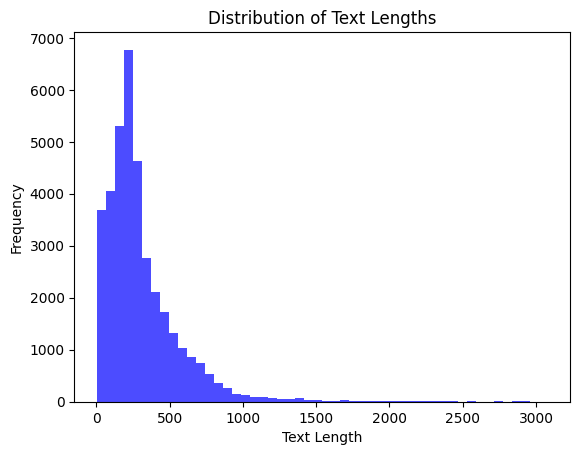

Mean Length: 309.46
Median Length: 239.00
90th Percentile: 623.00
Maximum Length: 3081.00


In [6]:

text_lengths = train_texts.apply(lambda x: len(str(x).split()))

import matplotlib.pyplot as plt
import numpy as np

plt.hist(text_lengths, bins=50, color='blue', alpha=0.7)
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")
plt.show()

print(f"Mean Length: {np.mean(text_lengths):.2f}")
print(f"Median Length: {np.median(text_lengths):.2f}")
print(f"90th Percentile: {np.percentile(text_lengths, 90):.2f}")
print(f"Maximum Length: {np.max(text_lengths):.2f}")


In [7]:
from NewsDatasetLSTM import NewsDatasetLSTM
from torch.utils.data import DataLoader

max_len = 623 
# Instantiate datasets
train_dataset = NewsDatasetLSTM(train_texts, train_labels, mod, max_len=max_len)
val_dataset = NewsDatasetLSTM(val_texts, val_labels, mod, max_len=max_len)
test_dataset = NewsDatasetLSTM(test_texts, test_labels, mod, max_len=max_len)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
from Training.utils import train_evaluate_and_test_models

num_negatives = len(df[df['label'] == 0])
num_positives = len(df[df['label'] == 1])
class_counts = [num_negatives, num_positives]

results = train_evaluate_and_test_models(class_counts,train_loader, val_loader, test_loader, epochs=10)


Training Model 1 (LSTM with Attention)


Evaluating: 100%|██████████| 193/193 [00:19<00:00,  9.65it/s]


New best model saved at checkpoints\LSTMWithAttention.pt with val_loss: 0.6702
Epoch 1/10
 Train Loss: 0.8164
 Val Loss: 0.6702
 Val Accuracy: 0.6736
 Val F1 Score: 0.7047
 Precision: 0.5846
 Recall: 0.8870
 Val AUC-ROC: 0.8368



Evaluating: 100%|██████████| 193/193 [00:19<00:00,  9.82it/s]


New best model saved at checkpoints\LSTMWithAttention.pt with val_loss: 0.4506
Epoch 2/10
 Train Loss: 0.5934
 Val Loss: 0.4506
 Val Accuracy: 0.8456
 Val F1 Score: 0.8297
 Precision: 0.8046
 Recall: 0.8564
 Val AUC-ROC: 0.9144



Evaluating: 100%|██████████| 193/193 [00:19<00:00,  9.81it/s]


New best model saved at checkpoints\LSTMWithAttention.pt with val_loss: 0.3114
Epoch 3/10
 Train Loss: 0.4791
 Val Loss: 0.3114
 Val Accuracy: 0.8784
 Val F1 Score: 0.8673
 Precision: 0.8326
 Recall: 0.9051
 Val AUC-ROC: 0.9535



Evaluating: 100%|██████████| 193/193 [00:19<00:00,  9.88it/s]


New best model saved at checkpoints\LSTMWithAttention.pt with val_loss: 0.2810
Epoch 4/10
 Train Loss: 0.3944
 Val Loss: 0.2810
 Val Accuracy: 0.8908
 Val F1 Score: 0.8847
 Precision: 0.8249
 Recall: 0.9537
 Val AUC-ROC: 0.9630



Evaluating: 100%|██████████| 193/193 [00:19<00:00,  9.87it/s]


New best model saved at checkpoints\LSTMWithAttention.pt with val_loss: 0.2396
Epoch 5/10
 Train Loss: 0.3431
 Val Loss: 0.2396
 Val Accuracy: 0.9192
 Val F1 Score: 0.9117
 Precision: 0.8763
 Recall: 0.9502
 Val AUC-ROC: 0.9731



Evaluating: 100%|██████████| 193/193 [00:20<00:00,  9.53it/s]


New best model saved at checkpoints\LSTMWithAttention.pt with val_loss: 0.2209
Epoch 6/10
 Train Loss: 0.3082
 Val Loss: 0.2209
 Val Accuracy: 0.9260
 Val F1 Score: 0.9189
 Precision: 0.8856
 Recall: 0.9548
 Val AUC-ROC: 0.9769



Evaluating: 100%|██████████| 193/193 [00:19<00:00,  9.85it/s]


New best model saved at checkpoints\LSTMWithAttention.pt with val_loss: 0.1961
Epoch 7/10
 Train Loss: 0.2727
 Val Loss: 0.1961
 Val Accuracy: 0.9385
 Val F1 Score: 0.9314
 Precision: 0.9125
 Recall: 0.9512
 Val AUC-ROC: 0.9818



Evaluating: 100%|██████████| 193/193 [00:19<00:00,  9.77it/s]


New best model saved at checkpoints\LSTMWithAttention.pt with val_loss: 0.1843
Epoch 8/10
 Train Loss: 0.2405
 Val Loss: 0.1843
 Val Accuracy: 0.9430
 Val F1 Score: 0.9363
 Precision: 0.9189
 Recall: 0.9545
 Val AUC-ROC: 0.9840



Evaluating: 100%|██████████| 193/193 [00:20<00:00,  9.64it/s]


New best model saved at checkpoints\LSTMWithAttention.pt with val_loss: 0.1770
Epoch 9/10
 Train Loss: 0.2259
 Val Loss: 0.1770
 Val Accuracy: 0.9422
 Val F1 Score: 0.9358
 Precision: 0.9136
 Recall: 0.9591
 Val AUC-ROC: 0.9853



Evaluating: 100%|██████████| 193/193 [00:19<00:00,  9.82it/s]


Performance did not improve: Current metric: 0.1776, best metric: 0.1770 Counter: 1/4
Epoch 10/10
 Train Loss: 0.2101
 Val Loss: 0.1776
 Val Accuracy: 0.9436
 Val F1 Score: 0.9371
 Precision: 0.9174
 Recall: 0.9578
 Val AUC-ROC: 0.9859


Testing with best model from checkpoint...
Checkpoint loaded from checkpoints\LSTMWithAttention.pt
Resuming from epoch 9


Evaluating: 100%|██████████| 194/194 [00:20<00:00,  9.69it/s]



Test Results:
Loss: 0.1954
Accuracy: 0.9347
F1 Score: 0.9277
Precision: 0.9020
Recall: 0.9549
ROC AUC: 0.9831


Training Model 2 (LSTM without Attention)


Evaluating: 100%|██████████| 193/193 [00:21<00:00,  8.81it/s]


New best model saved at checkpoints\LSTMWithoutAttention.pt with val_loss: 0.7725
Epoch 1/10
 Train Loss: 0.7904
 Val Loss: 0.7725
 Val Accuracy: 0.4730
 Val F1 Score: 0.6167
 Precision: 0.4531
 Recall: 0.9652
 Val AUC-ROC: 0.5291



Evaluating: 100%|██████████| 193/193 [00:21<00:00,  8.85it/s]


New best model saved at checkpoints\LSTMWithoutAttention.pt with val_loss: 0.7684
Epoch 2/10
 Train Loss: 0.7777
 Val Loss: 0.7684
 Val Accuracy: 0.4773
 Val F1 Score: 0.6189
 Precision: 0.4552
 Recall: 0.9665
 Val AUC-ROC: 0.6294



Evaluating: 100%|██████████| 193/193 [00:21<00:00,  8.80it/s]


New best model saved at checkpoints\LSTMWithoutAttention.pt with val_loss: 0.7602
Epoch 3/10
 Train Loss: 0.7654
 Val Loss: 0.7602
 Val Accuracy: 0.5656
 Val F1 Score: 0.1054
 Precision: 0.5515
 Recall: 0.0582
 Val AUC-ROC: 0.5804



Evaluating: 100%|██████████| 193/193 [00:21<00:00,  8.86it/s]


New best model saved at checkpoints\LSTMWithoutAttention.pt with val_loss: 0.5344
Epoch 4/10
 Train Loss: 0.6091
 Val Loss: 0.5344
 Val Accuracy: 0.8199
 Val F1 Score: 0.7749
 Precision: 0.8593
 Recall: 0.7056
 Val AUC-ROC: 0.8568



Evaluating: 100%|██████████| 193/193 [00:21<00:00,  8.85it/s]


Performance did not improve: Current metric: 0.5819, best metric: 0.5344 Counter: 1/4
Epoch 5/10
 Train Loss: 0.5458
 Val Loss: 0.5819
 Val Accuracy: 0.7796
 Val F1 Score: 0.7720
 Precision: 0.7076
 Recall: 0.8492
 Val AUC-ROC: 0.8405



Evaluating: 100%|██████████| 193/193 [00:21<00:00,  8.79it/s]


New best model saved at checkpoints\LSTMWithoutAttention.pt with val_loss: 0.5225
Epoch 6/10
 Train Loss: 0.5362
 Val Loss: 0.5225
 Val Accuracy: 0.8283
 Val F1 Score: 0.7926
 Precision: 0.8440
 Recall: 0.7471
 Val AUC-ROC: 0.8653



Evaluating: 100%|██████████| 193/193 [00:21<00:00,  8.89it/s]


Performance did not improve: Current metric: 0.5569, best metric: 0.5225 Counter: 1/4
Epoch 7/10
 Train Loss: 0.5544
 Val Loss: 0.5569
 Val Accuracy: 0.8069
 Val F1 Score: 0.7834
 Precision: 0.7722
 Recall: 0.7948
 Val AUC-ROC: 0.8484



Evaluating: 100%|██████████| 193/193 [00:21<00:00,  8.81it/s]


Performance did not improve: Current metric: 0.5441, best metric: 0.5225 Counter: 2/4
Epoch 8/10
 Train Loss: 0.5381
 Val Loss: 0.5441
 Val Accuracy: 0.8142
 Val F1 Score: 0.7544
 Precision: 0.8994
 Recall: 0.6496
 Val AUC-ROC: 0.8656



Evaluating: 100%|██████████| 193/193 [00:21<00:00,  8.89it/s]


Performance did not improve: Current metric: 0.5984, best metric: 0.5225 Counter: 3/4
Epoch 9/10
 Train Loss: 0.5308
 Val Loss: 0.5984
 Val Accuracy: 0.7576
 Val F1 Score: 0.7543
 Precision: 0.6797
 Recall: 0.8474
 Val AUC-ROC: 0.8054



Evaluating: 100%|██████████| 193/193 [00:31<00:00,  6.04it/s]



Learning rate changed: 0.000100 -> 0.000050
Performance did not improve: Current metric: 0.5730, best metric: 0.5225 Counter: 4/4
Stopping early. Best performance: 0.5225
Epoch 10/10
 Train Loss: 0.5599
 Val Loss: 0.5730
 Val Accuracy: 0.7868
 Val F1 Score: 0.7745
 Precision: 0.7230
 Recall: 0.8339
 Val AUC-ROC: 0.8331


Testing with best model from checkpoint...
Checkpoint loaded from checkpoints\LSTMWithoutAttention.pt
Resuming from epoch 6


Evaluating: 100%|██████████| 194/194 [00:29<00:00,  6.52it/s]



Test Results:
Loss: 0.5257
Accuracy: 0.8250
F1 Score: 0.7879
Precision: 0.8419
Recall: 0.7405
ROC AUC: 0.8652



In [9]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from typing import Dict, Optional, List
# from pathlib import Path

# class ModelComparisonVisualizer:
# 	"""
# 	A class for visualizing and comparing metrics between multiple models.
# 	Specifically designed for LSTM models with and without attention.
# 	"""
	
# 	def __init__(self, style: str = 'seaborn-v0_8-darkgrid'):
# 		"""
# 		Initialize the visualizer.
		
# 		Args:
# 			style (str): The matplotlib style to use
# 		"""
# 		self.style = style
# 		plt.style.use(style)
		
# 		self.colors = {
# 			'Model 1': '#2ecc71',
# 			'Model 2': '#e74c3c',
# 			'train': '#3498db',
# 			'val': '#f1c40f',
# 			'test': '#9b59b6',
# 			'grid': '#ecf0f1'
# 		}
# 		self.save_dir = Path('Results')
# 		self.save_dir.mkdir(parents=True, exist_ok=True)
	
# 	def create_comparison_dashboard(self, results: Dict, save_path: Optional[str] = None) -> plt.Figure:
# 		"""
# 		Create a comprehensive dashboard comparing both models.
		
# 		Args:
# 			results: Dictionary containing results for both models
# 			save_path: Optional path to save the dashboard
# 		"""
# 		fig = plt.figure(figsize=(20, 15)) 
# 		gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)
		
# 		# Plot training and validation metrics
# 		metrics = ['accuracy', 'precision', 'recall', 'f1_score']
# 		positions = [(0,0), (0,1), (1,0), (1,1)]
		
# 		for metric, pos in zip(metrics, positions):
# 			ax = fig.add_subplot(gs[pos])
# 			self._plot_metric_comparison(ax, results, metric)
			
# 		# Add test metrics summary
# 		ax_test = fig.add_subplot(gs[0:2, 2])
# 		self._plot_test_metrics_summary(ax_test, results)
		
# 		# Add confusion matrices
# 		ax_conf_m1 = fig.add_subplot(gs[2, 0])
# 		ax_conf_m2 = fig.add_subplot(gs[2, 1])
# 		self._plot_confusion_matrices(ax_conf_m1, ax_conf_m2, results)
		
# 		plt.suptitle('Model Comparison Dashboard', fontsize=16, y=1)
		
# 		if save_path:
# 			plt.savefig(self.save_dir/ save_path, bbox_inches='tight', dpi=300)
			
# 		return fig
	
# 	def plot_detailed_metrics(self, results: Dict, save_path: Optional[str] = None) -> plt.Figure:
# 		"""
# 		Create detailed plots for each metric including training, validation, and test results.
		
# 		Args:
# 			results: Dictionary containing results for both models
# 			save_path: Optional path to save the dashboard
# 		"""
# 		metrics = ['accuracy', 'precision', 'recall', 'f1_score']
# 		fig, axes = plt.subplots(2, 2, figsize=(15, 12))
# 		axes = axes.ravel()
		
# 		for idx, metric in enumerate(metrics):
# 			ax = axes[idx]
# 			self._plot_detailed_metric(ax, results, metric)
			
# 		plt.tight_layout()
		
# 		if save_path:
# 			plt.savefig(self.save_dir/ save_path, bbox_inches='tight', dpi=300)
			
# 		return fig
	
# 	def _plot_detailed_metric(self, ax: plt.Axes, results: Dict, metric: str) -> None:
# 		"""Plot detailed view of a specific metric including training and validation."""
		
# 		for model_name in ['Model 1', 'Model 2']:
# 			epochs = range(1, len(results[model_name]['training_metrics'][metric]['val']) + 1)
# 			train_scores = results[model_name]['training_metrics'][metric]['train']
# 			val_scores = results[model_name]['training_metrics'][metric]['val']
# 			test_score = results[model_name]['test_metrics'][metric]
			
# 			# Plot training and validation lines
# 			ax.plot(epochs, train_scores, '--', 
# 				   label=f'{model_name} (Train)', 
# 				   color=self.colors[model_name], 
# 				   alpha=0.5)
# 			ax.plot(epochs, val_scores, '-', 
# 				   label=f'{model_name} (Val)', 
# 				   color=self.colors[model_name])
			
# 			# Plot test score as a horizontal line
# 			ax.axhline(y=test_score, color=self.colors[model_name], 
# 					  linestyle=':', label=f'{model_name} (Test)', 
# 					  alpha=0.7)
			
# 		ax.set_title(f'{metric.replace("_", " ").title()}')
# 		ax.set_xlabel('Epoch')
# 		ax.set_ylabel('Score')
# 		ax.legend()
# 		ax.grid(True, alpha=0.3)
# 		ax.set_ylim(0, 1)  # Set y-axis limits
	
# 	def plot_model_comparison_summary(self, results: Dict, save_path: Optional[str] = None) -> plt.Figure:
# 		"""
# 		Create a summary plot comparing both models across all metrics.
		
# 		Args:
# 			results: Dictionary containing results for both models
# 			save_path: Optional path to save the plot
# 		"""
# 		fig, ax = plt.subplots(figsize=(10, 6))
# 		metrics = ['accuracy', 'precision', 'recall', 'f1_score']
		
# 		x = np.arange(len(metrics))
# 		width = 0.35
		
# 		# Plot bars for each model
# 		for i, model_name in enumerate(['Model 1', 'Model 2']):
# 			test_scores = [results[model_name]['test_metrics'][metric] for metric in metrics]
# 			ax.bar(x + i*width, test_scores, width, label=model_name, color=self.colors[model_name], alpha=0.7)
		
# 		ax.set_ylabel('Score')
# 		ax.set_title('Model Comparison - Test Metrics')
# 		ax.set_xticks(x + width/2)
# 		ax.set_xticklabels(metrics)
# 		ax.legend()
# 		ax.grid(True, alpha=0.3)
# 		ax.set_ylim(0, 1)  # Set y-axis limits
		
# 		if save_path:
# 			plt.savefig(self.save_dir/ save_path, bbox_inches='tight', dpi=300)
			
# 		return fig
	
# 	def _plot_confusion_matrices(self, ax1: plt.Axes, ax2: plt.Axes, results: Dict) -> None:
# 		"""
# 		Plot confusion matrices for both models side by side.
		
# 		Args:
# 			ax1: Axes for Model 1's confusion matrix
# 			ax2: Axes for Model 2's confusion matrix
# 			results: Dictionary containing results for both models
# 		"""
# 		for ax, (model_name, title) in zip([ax1, ax2], 
# 										 [('Model 1', 'LSTM with Attention'),
# 										  ('Model 2', 'LSTM without Attention')]):
			
# 			# Get the confusion matrix from test metrics
# 			cm = results[model_name]['test_metrics']['confusion_matrix']
			
# 			# Create heatmap
# 			sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
# 					   xticklabels=['Negative', 'Positive'],
# 					   yticklabels=['Negative', 'Positive'])
			
# 			# Customize the plot
# 			ax.set_title(f'Confusion Matrix\n{title}')
# 			ax.set_xlabel('Predicted')
# 			ax.set_ylabel('Actual')
	
# 	def plot_confusion_matrix_comparison(self, results: Dict, save_path: Optional[str] = None) -> plt.Figure:
# 		"""
# 		Create a standalone figure comparing confusion matrices between models.
		
# 		Args:
# 			results: Dictionary containing results for both models
# 			save_path: Optional path to save the plot
# 		"""
# 		fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
		
# 		self._plot_confusion_matrices(ax1, ax2, results)
		
# 		plt.suptitle('Confusion Matrix Comparison', fontsize=14)
# 		plt.tight_layout()
		
# 		if save_path:
# 			plt.savefig(self.save_dir/ save_path, bbox_inches='tight', dpi=300)
			
# 		return fig
	
# 	def _plot_metric_comparison(self, ax: plt.Axes, results: Dict, metric: str) -> None:
# 		"""Plot comparison of a specific metric for both models."""

# 		for model_name in ['Model 1', 'Model 2']:
# 			epochs = range(1, len(results[model_name]['training_metrics'][metric]['val']) + 1)

# 			val_scores = results[model_name]['training_metrics'][metric]['val']
# 			ax.plot(epochs, val_scores, label=f'{model_name} (Val)', color=self.colors[model_name])
# 		ax.set_title(f'{metric.replace("_", " ").title()} Comparison')
# 		ax.set_xlabel('Epoch')
# 		ax.set_ylabel('Score')
# 		ax.legend()
# 		ax.grid(True, alpha=0.3)
# 		ax.set_ylim(0, 1)
	
# 	def _plot_test_metrics_summary(self, ax: plt.Axes, results: Dict) -> None:
# 		"""Plot summary of test metrics for both models."""
# 		metrics = ['accuracy', 'precision', 'recall', 'f1_score']
# 		x = np.arange(len(metrics))
# 		width = 0.35
		
# 		for i, model_name in enumerate(['Model 1', 'Model 2']):
# 			test_scores = [results[model_name]['test_metrics'][metric] for metric in metrics]
# 			ax.bar(x + i*width, test_scores, width, label=model_name, color=self.colors[model_name], alpha=0.7)
		
# 		ax.set_ylabel('Score')
# 		ax.set_title('Test Metrics Comparison')
# 		ax.set_xticks(x + width/2)
# 		ax.set_xticklabels(metrics)
# 		ax.legend()
# 		ax.grid(True, alpha=0.3)
# 		ax.set_ylim(0, 1)

# # Example usage
# def visualize_results(results):
# 	"""
# 	Create and save all visualizations for the model comparison.
	
# 	Args:
# 		results: Dictionary containing results for both models
# 	"""
# 	visualizer = ModelComparisonVisualizer()
	
# 	# Create and save the main comparison dashboard
# 	visualizer.create_comparison_dashboard(results, 'model_comparison_dashboard.png')
	
# 	# Create and save detailed metrics plots
# 	visualizer.plot_detailed_metrics(results, 'detailed_metrics.png')
	
# 	# Create and save the summary comparison
# 	visualizer.plot_model_comparison_summary(results, 'model_comparison_summary.png')
	
# 	# Create and save confusion matrix comparison
# 	visualizer.plot_confusion_matrix_comparison(results, 'confusion_matrix_comparison.png')
	
# 	plt.show()

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Dict, Optional
from pathlib import Path

class ModelMetricsVisualizer:
	"""
	A class for visualizing model metrics in a publication-ready format.
	"""
	
	def __init__(self):
		"""Initialize the visualizer with publication-friendly settings."""
		plt.rcParams.update({
			'font.family': 'serif',
			'font.size': 10,
			'axes.labelsize': 10,
			'axes.titlesize': 10,
			'xtick.labelsize': 9,
			'ytick.labelsize': 9,
			'legend.fontsize': 9,
			'figure.dpi': 300
		})
		
		self.colors = {
			'Model 1': '#0077BB',
			'Model 2': '#EE3377',
		}
		
		self.line_styles = {
			'train': (0, (1, 1)),
			'val': 'solid',
			'test': (0, (5, 1))
		}
		
		self.save_dir = Path('Results')
		self.save_dir.mkdir(parents=True, exist_ok=True)
	
	def plot_metric(self, results: Dict, metric: str, save_path: Optional[str] = None) -> plt.Figure:
		"""
		Create a publication-ready plot for a specific metric.
		
		Args:
			results: Dictionary containing results for both models
			metric: The metric to plot (accuracy, precision, recall, or f1_score)
			save_path: Optional path to save the plot
		"""
		fig, ax = plt.subplots(figsize=(8, 5))
		
		for model_name in ['Model 1', 'Model 2']:
			epochs = range(1, len(results[model_name]['training_metrics'][metric]['val']) + 1)
			train_scores = results[model_name]['training_metrics'][metric]['train']
			val_scores = results[model_name]['training_metrics'][metric]['val']
			test_score = results[model_name]['test_metrics'][metric]
			
			# Training and validation curves
			ax.plot(epochs, train_scores, 
				   linestyle=self.line_styles['train'],
				   color=self.colors[model_name],
				   label=f'{model_name} (Train)',
				   linewidth=1.5)
			
			ax.plot(epochs, val_scores,
				   linestyle=self.line_styles['val'],
				   color=self.colors[model_name],
				   label=f'{model_name} (Val)',
				   linewidth=1.5)
			
			# Test score line
			ax.axhline(y=test_score,
					  linestyle=self.line_styles['test'],
					  color=self.colors[model_name],
					  label=f'{model_name} (Test)',
					  linewidth=1, alpha=0.7)
		
		ax.set_xlabel('Epoch')
		ax.set_ylabel(metric.replace('_', ' ').title())
		ax.set_ylim(0, 1)
		ax.set_xlim(0, len(epochs) + 1)
		
		ax.grid(True, linestyle=':', alpha=0.3)
		
		ax.legend(loc='center right',
				 bbox_to_anchor=(0.98, 0.5),
				 frameon=True,
				 fancybox=True,
				 framealpha=0.9)
		
		plt.title(f'{metric.replace("_", " ").title()} Comparison')
		plt.tight_layout(pad=1.5)
		
		if save_path:
			plt.savefig(self.save_dir / f'{metric}_{save_path}.png',
					   bbox_inches='tight',
					   dpi=300)
			
		return fig
	
	def plot_confusion_matrix(self, results: Dict, save_path: Optional[str] = None) -> plt.Figure:
		"""
		Create a publication-ready confusion matrix comparison.
		
		Args:
			results: Dictionary containing results for both models
			save_path: Optional path to save the plot
		"""
		figures = []
	
		for model_name, title in [('Model 1', 'LSTM with Attention'),
								('Model 2', 'LSTM without Attention')]:
			
			# Extract the confusion matrix
			cm = results[model_name]['test_metrics']['confusion_matrix']
			
			# Create a new figure
			fig, ax = plt.subplots(figsize=(6, 5))
			
			# Plot the heatmap
			sns.heatmap(cm, annot=True, fmt='d',
						cmap='Blues',
						xticklabels=['Negative', 'Positive'],
						yticklabels=['Negative', 'Positive'],
						cbar=True, ax=ax)
			
			# Set titles and labels
			ax.set_title(title, pad=10)
			ax.set_xlabel('Predicted')
			ax.set_ylabel('Actual')

			plt.tight_layout(pad=2.0, w_pad=3.0)
			
			# Save the figure if save_path is provided
			if save_path:
				fig.savefig(f"{self.save_dir /save_path}_{model_name.replace(' ', '_')}.png",
							bbox_inches='tight',
							dpi=300)
			
			# Append the figure to the list
			figures.append(fig)
		
		return figures



def visualize_results(results):
	"""
	Create and save publication-ready visualizations.
	
	Args:
		results: Dictionary containing results for both models
	"""
	visualizer = ModelMetricsVisualizer()
	
	metrics = ['accuracy', 'precision', 'recall', 'f1_score']
	for metric in metrics:
		visualizer.plot_metric(results, metric, f'{metric}_comparison')
	
	visualizer.plot_confusion_matrix(results, 'confusion_matrix_comparison')
	
	plt.show()

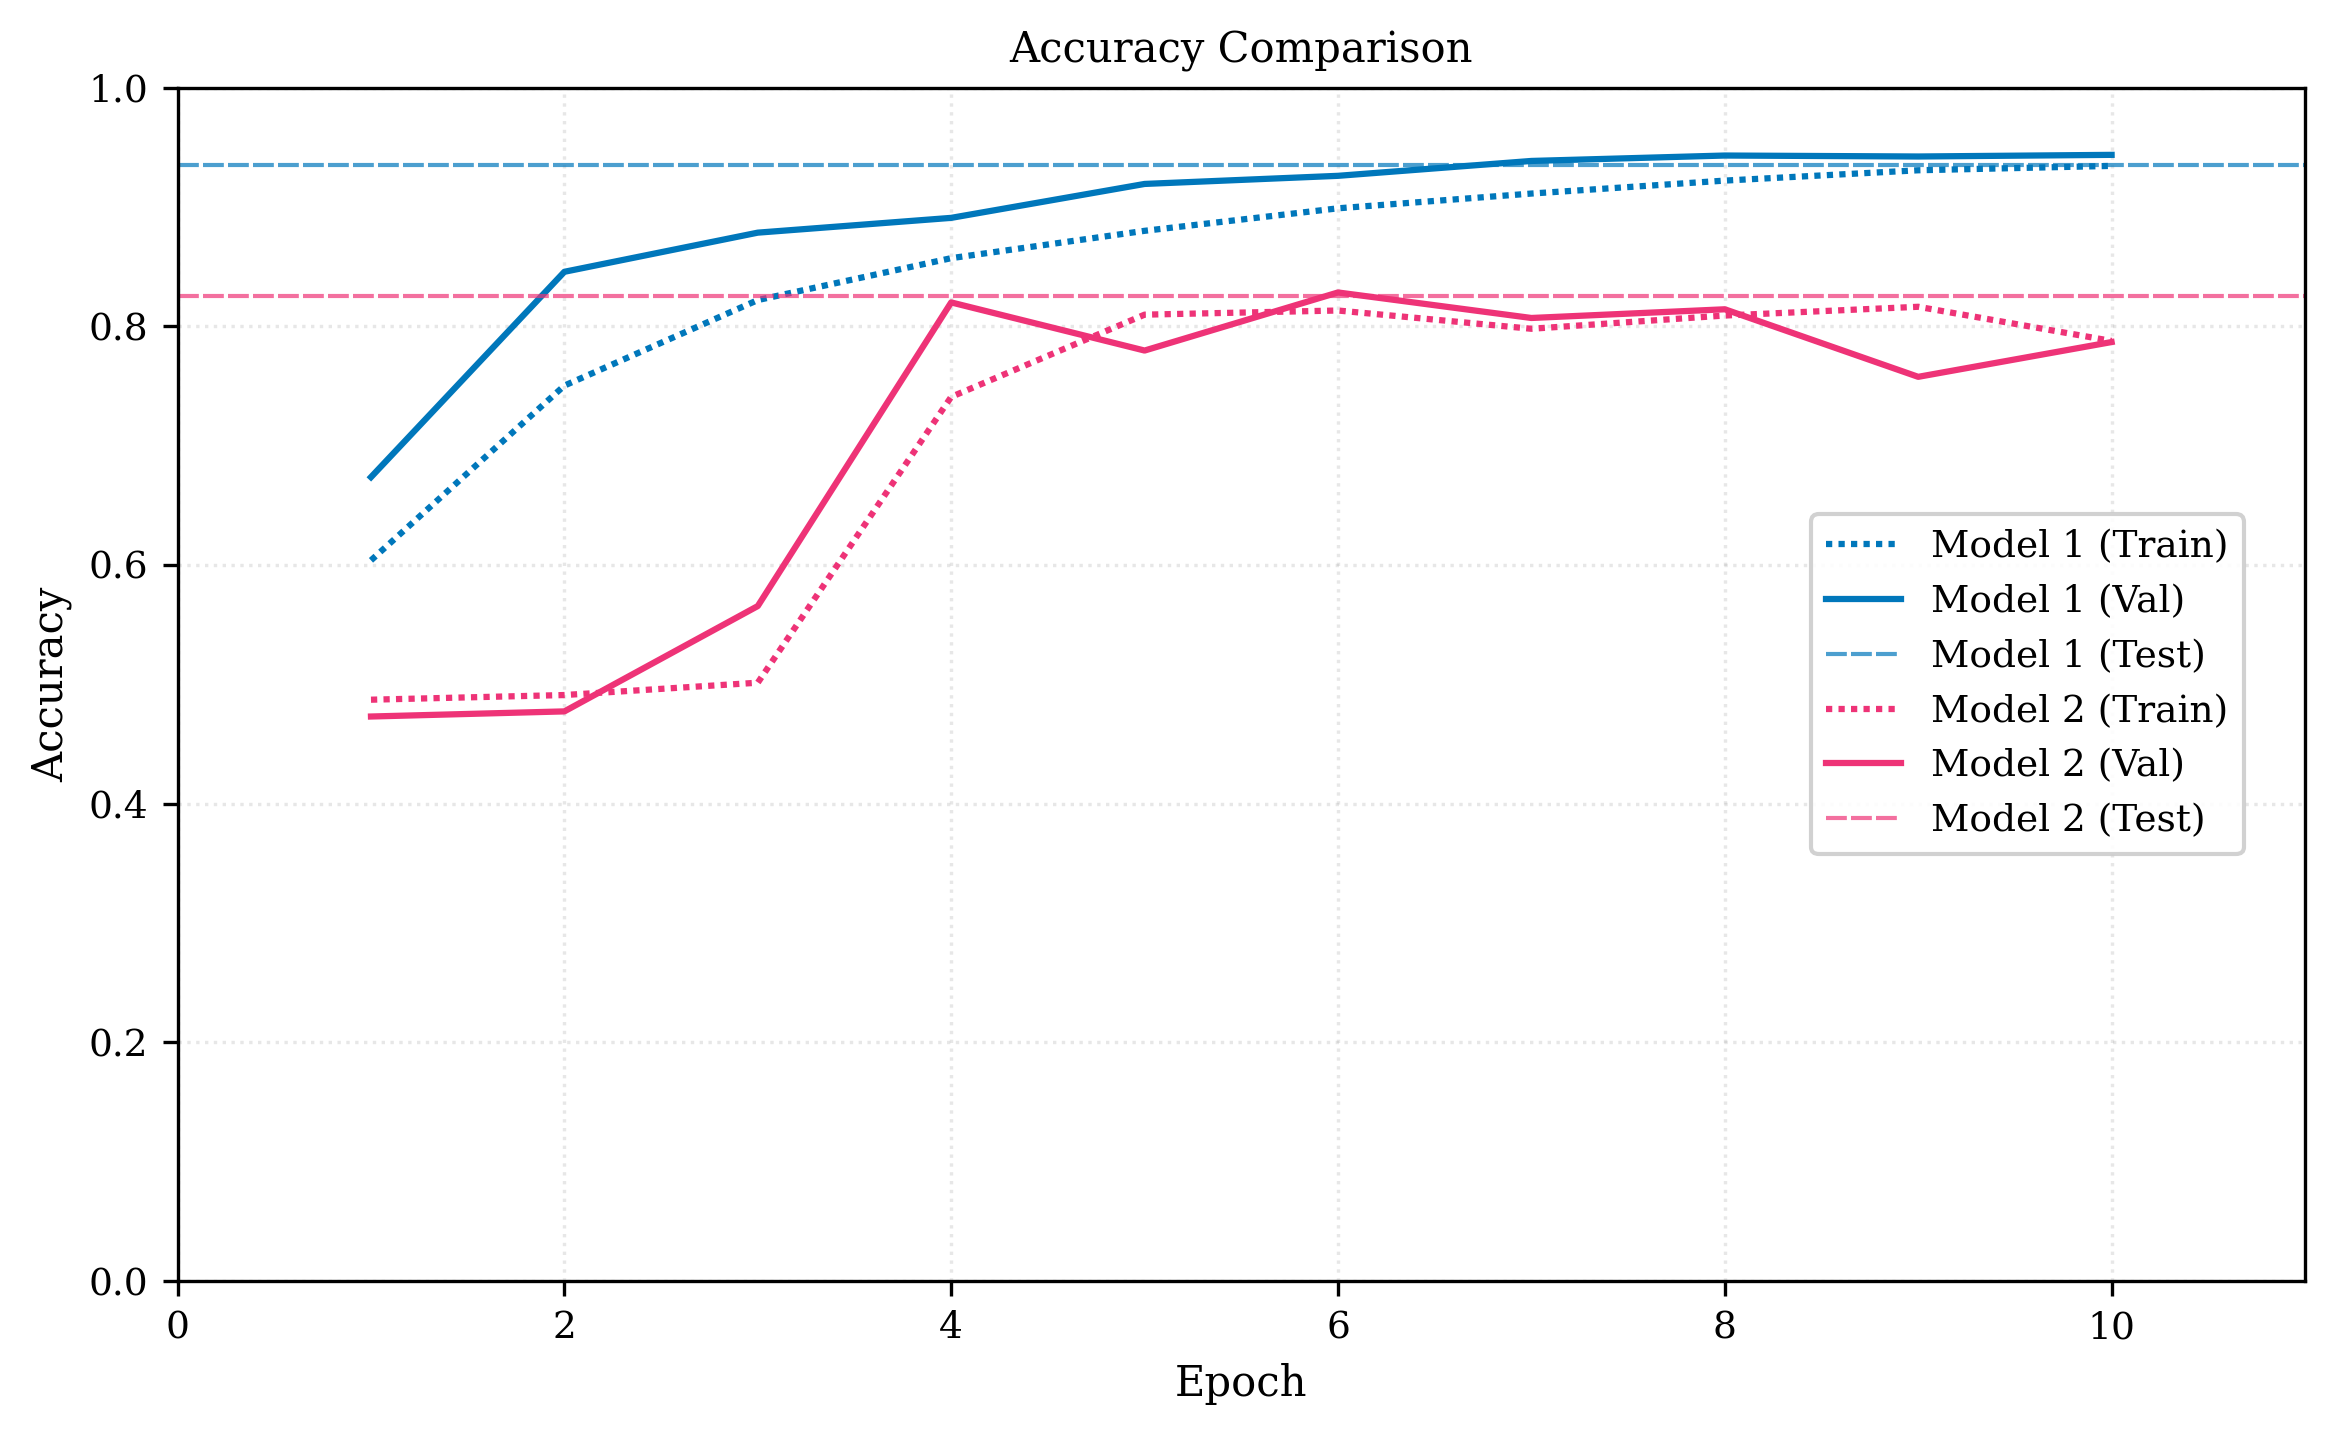

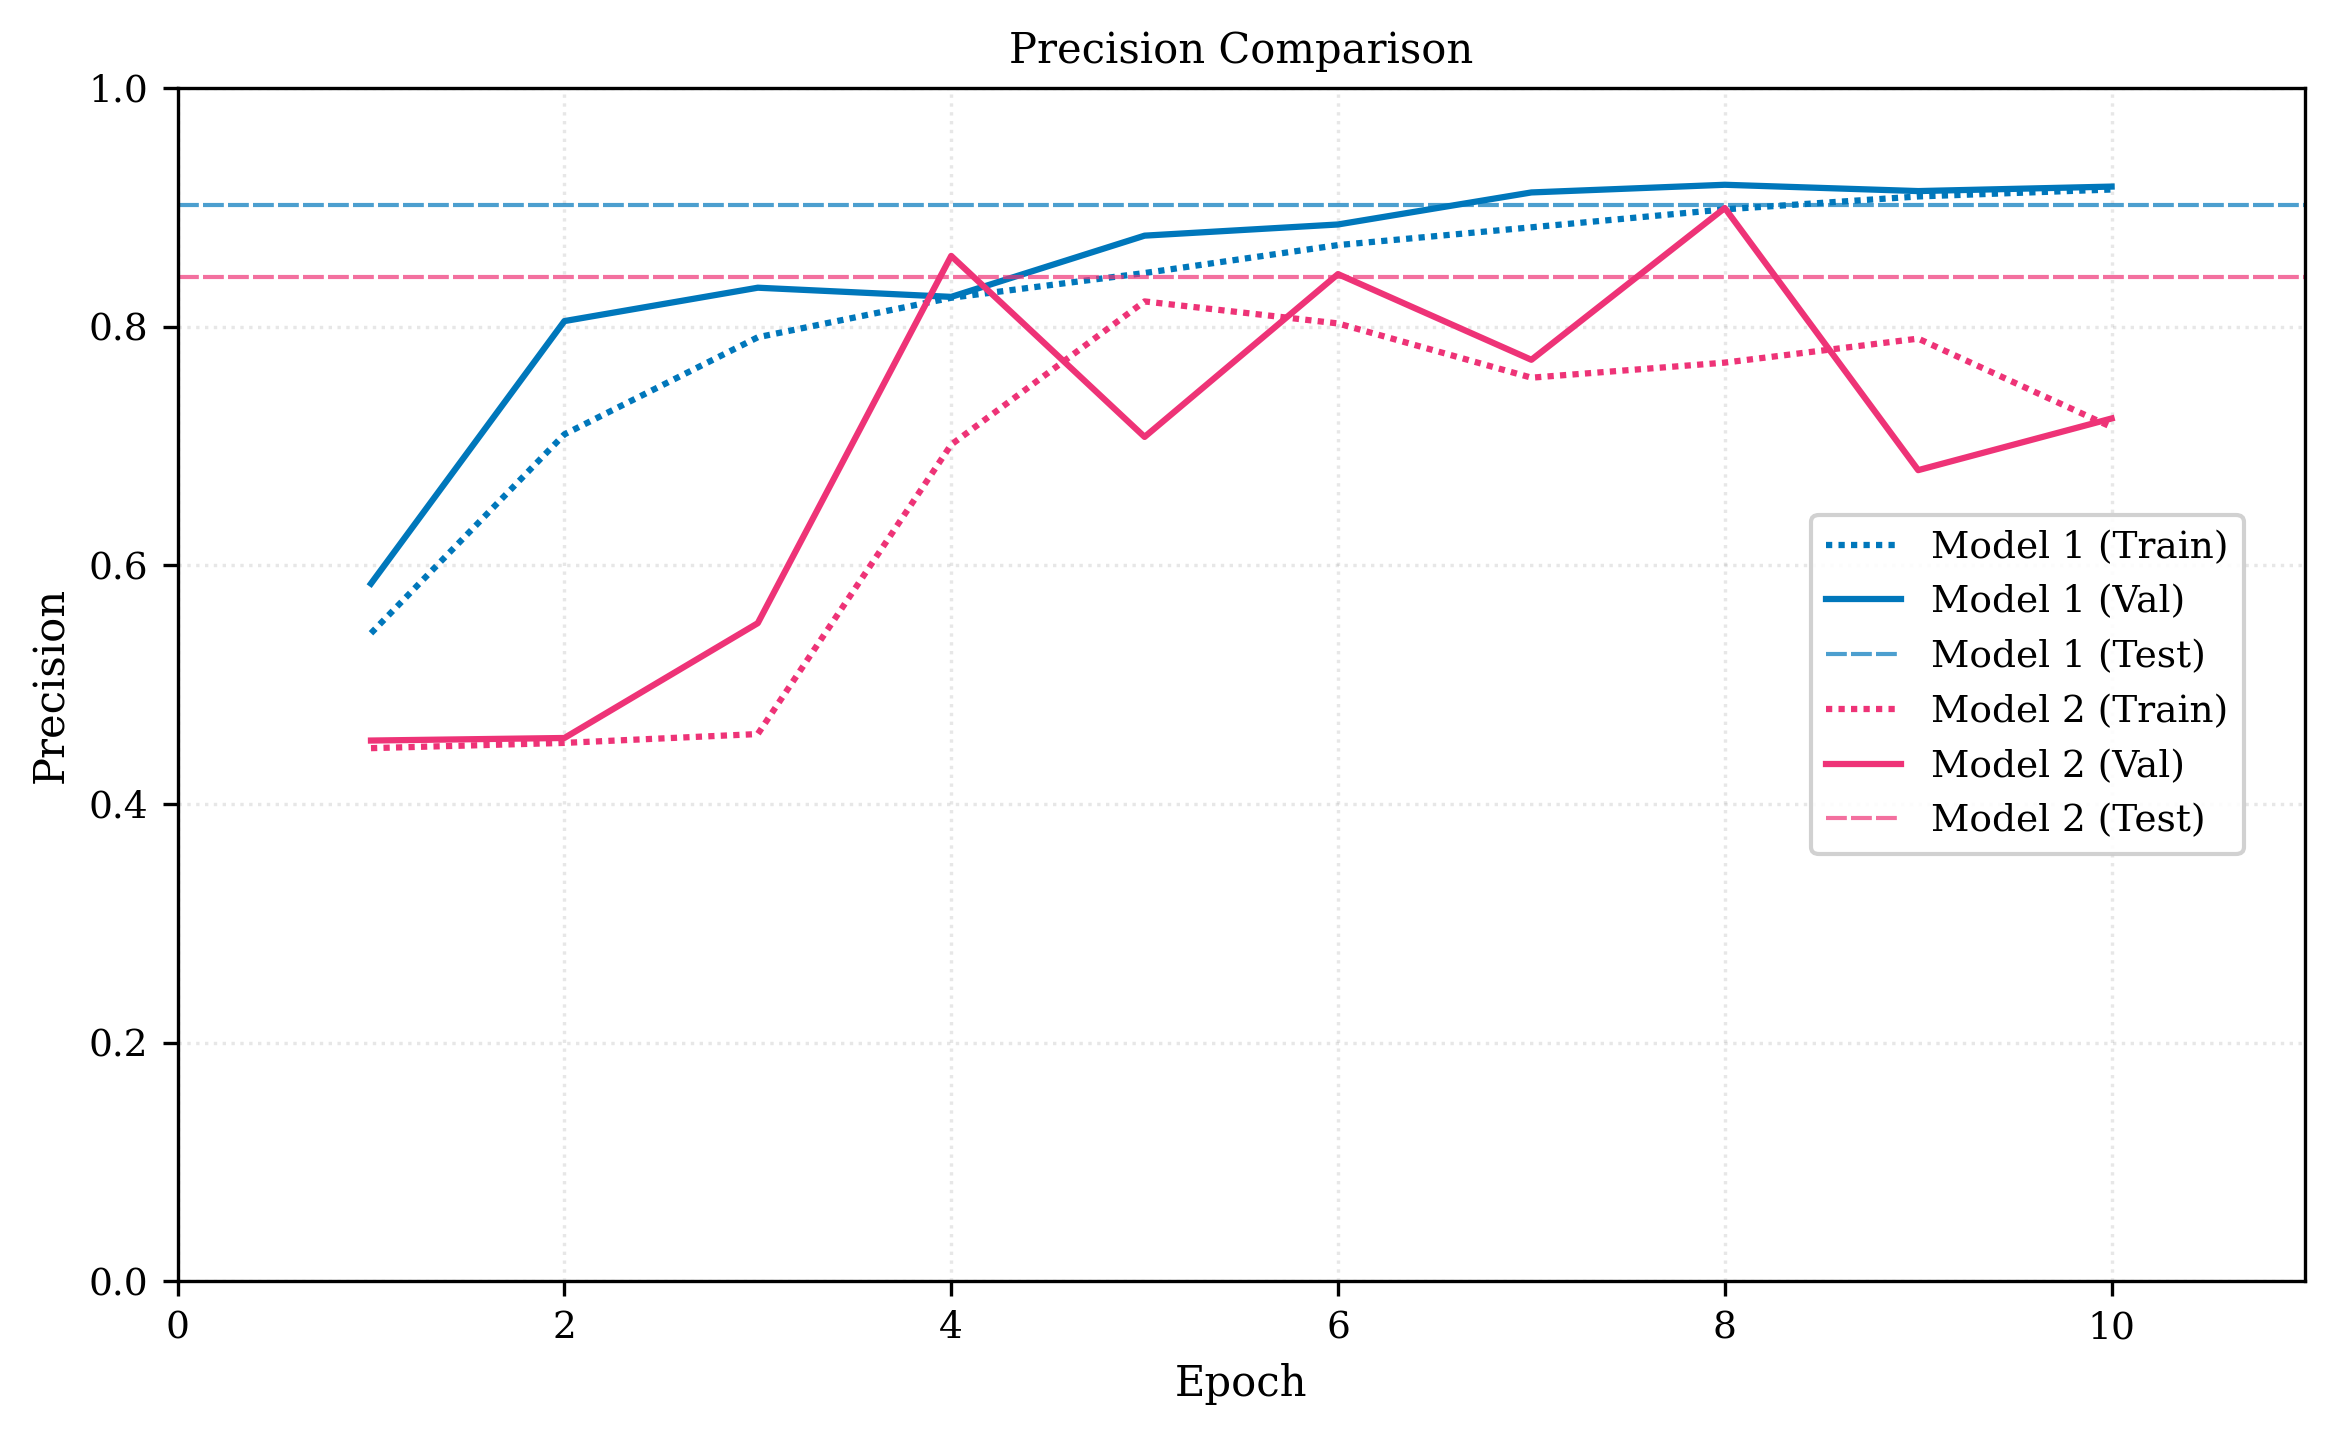

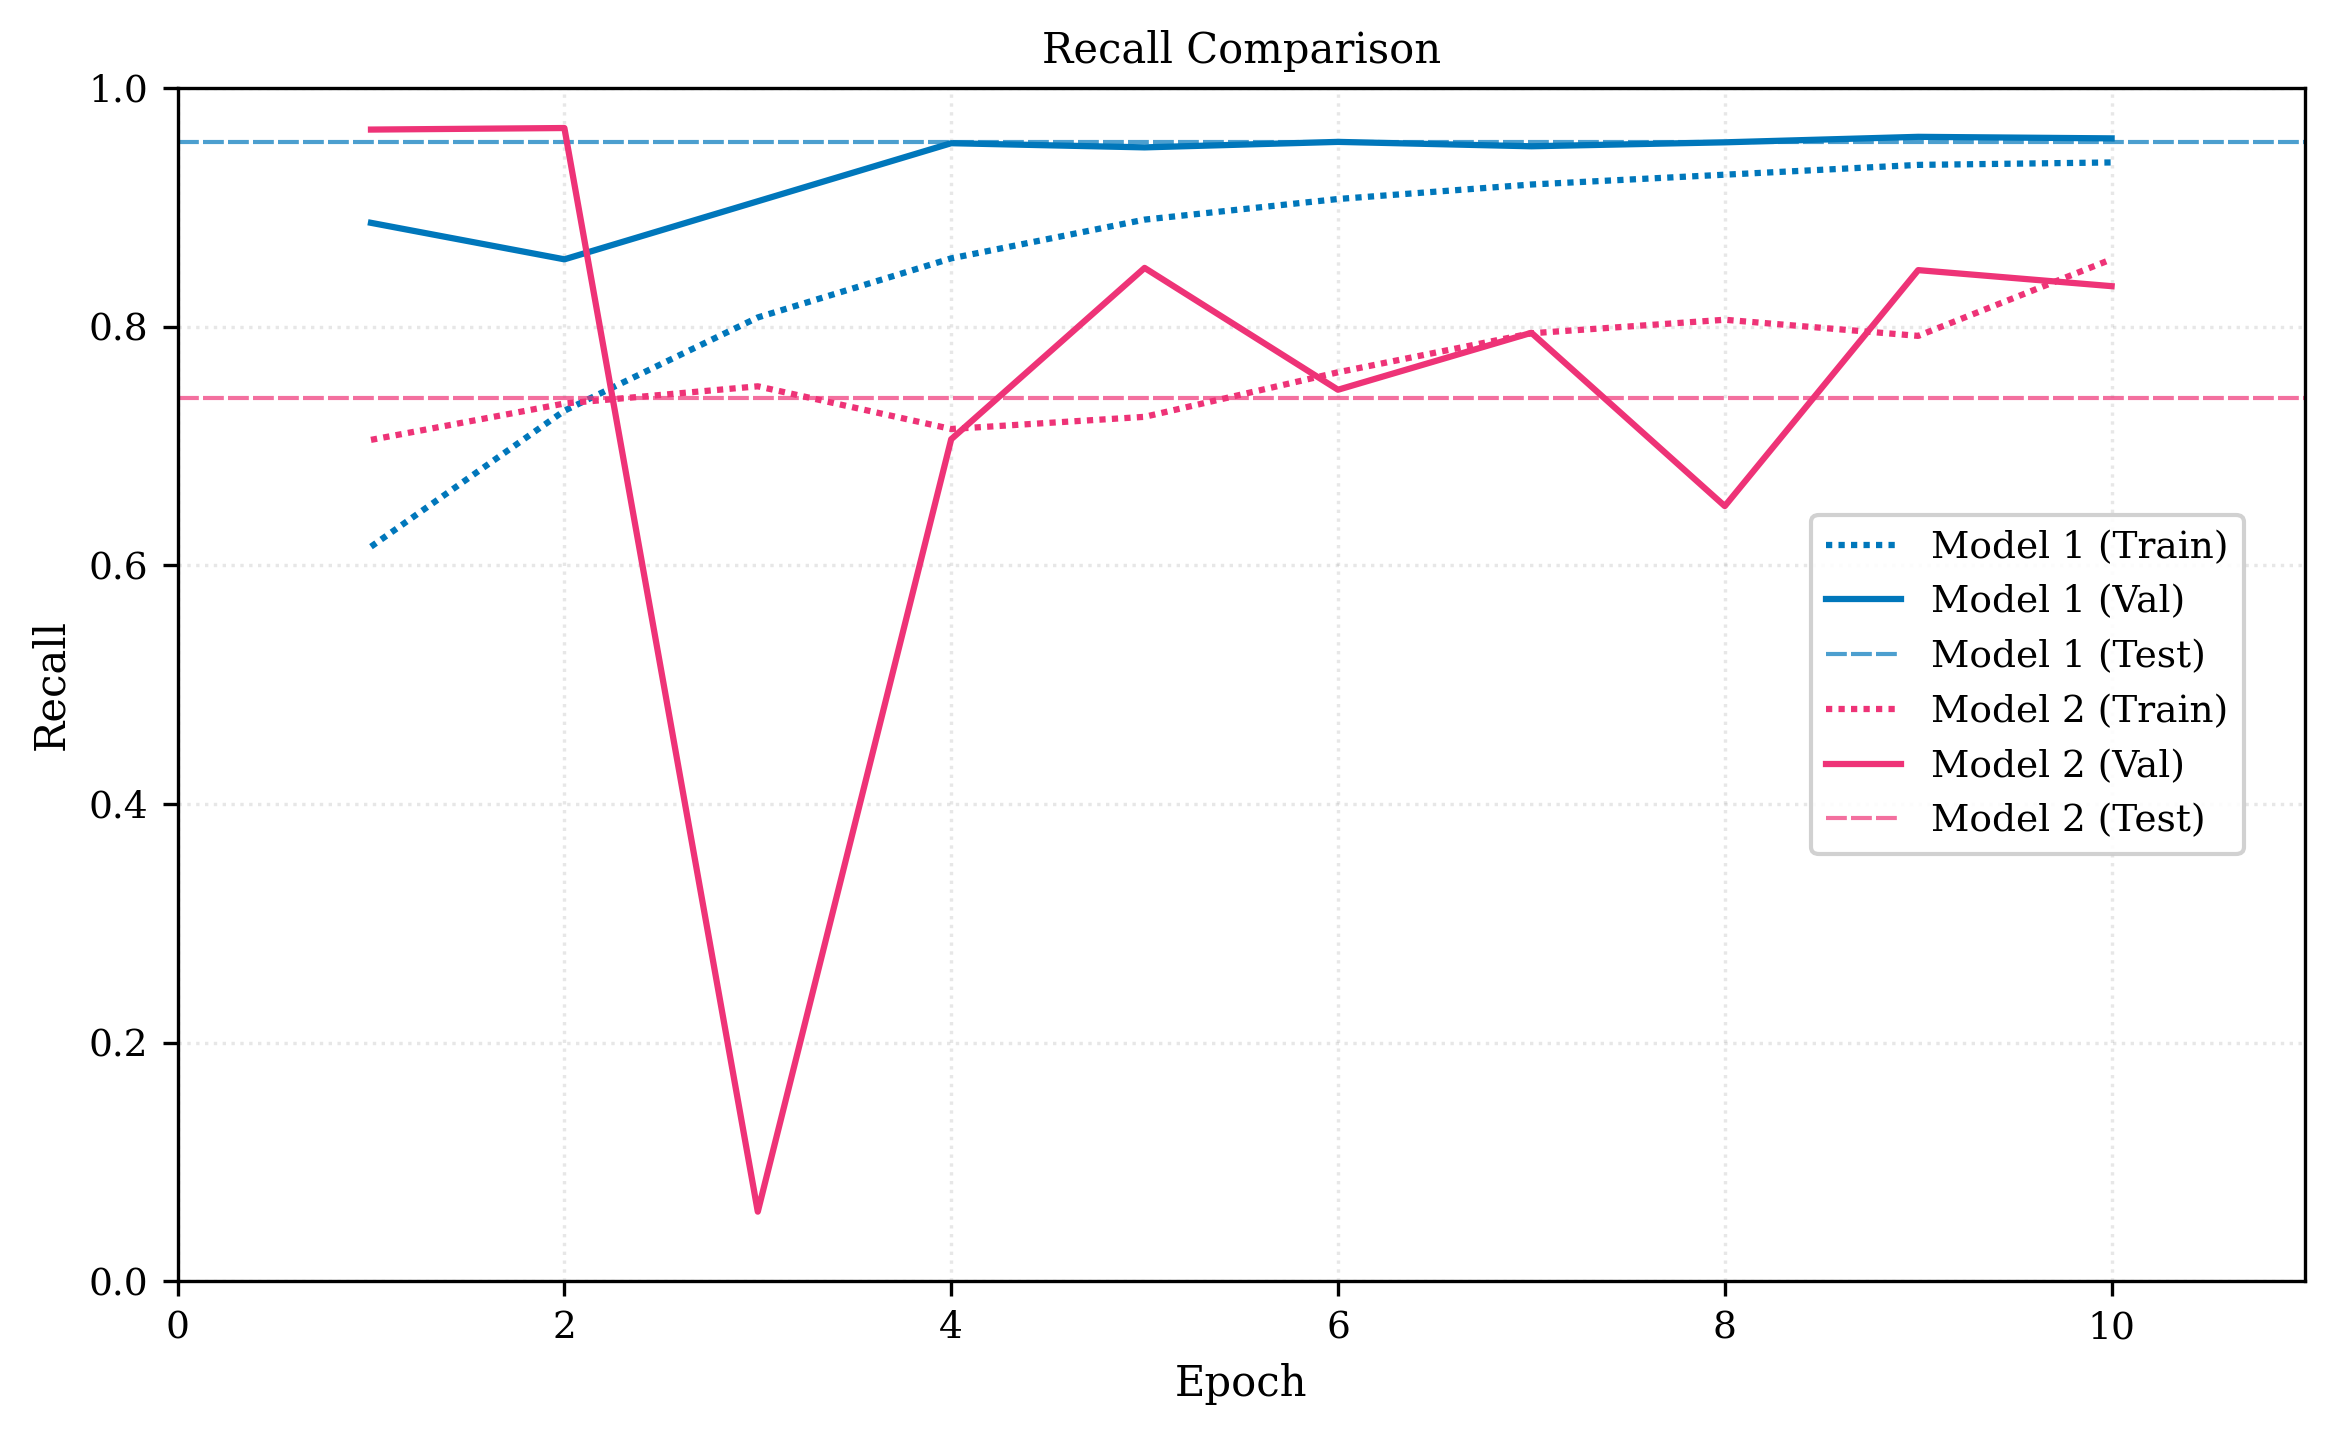

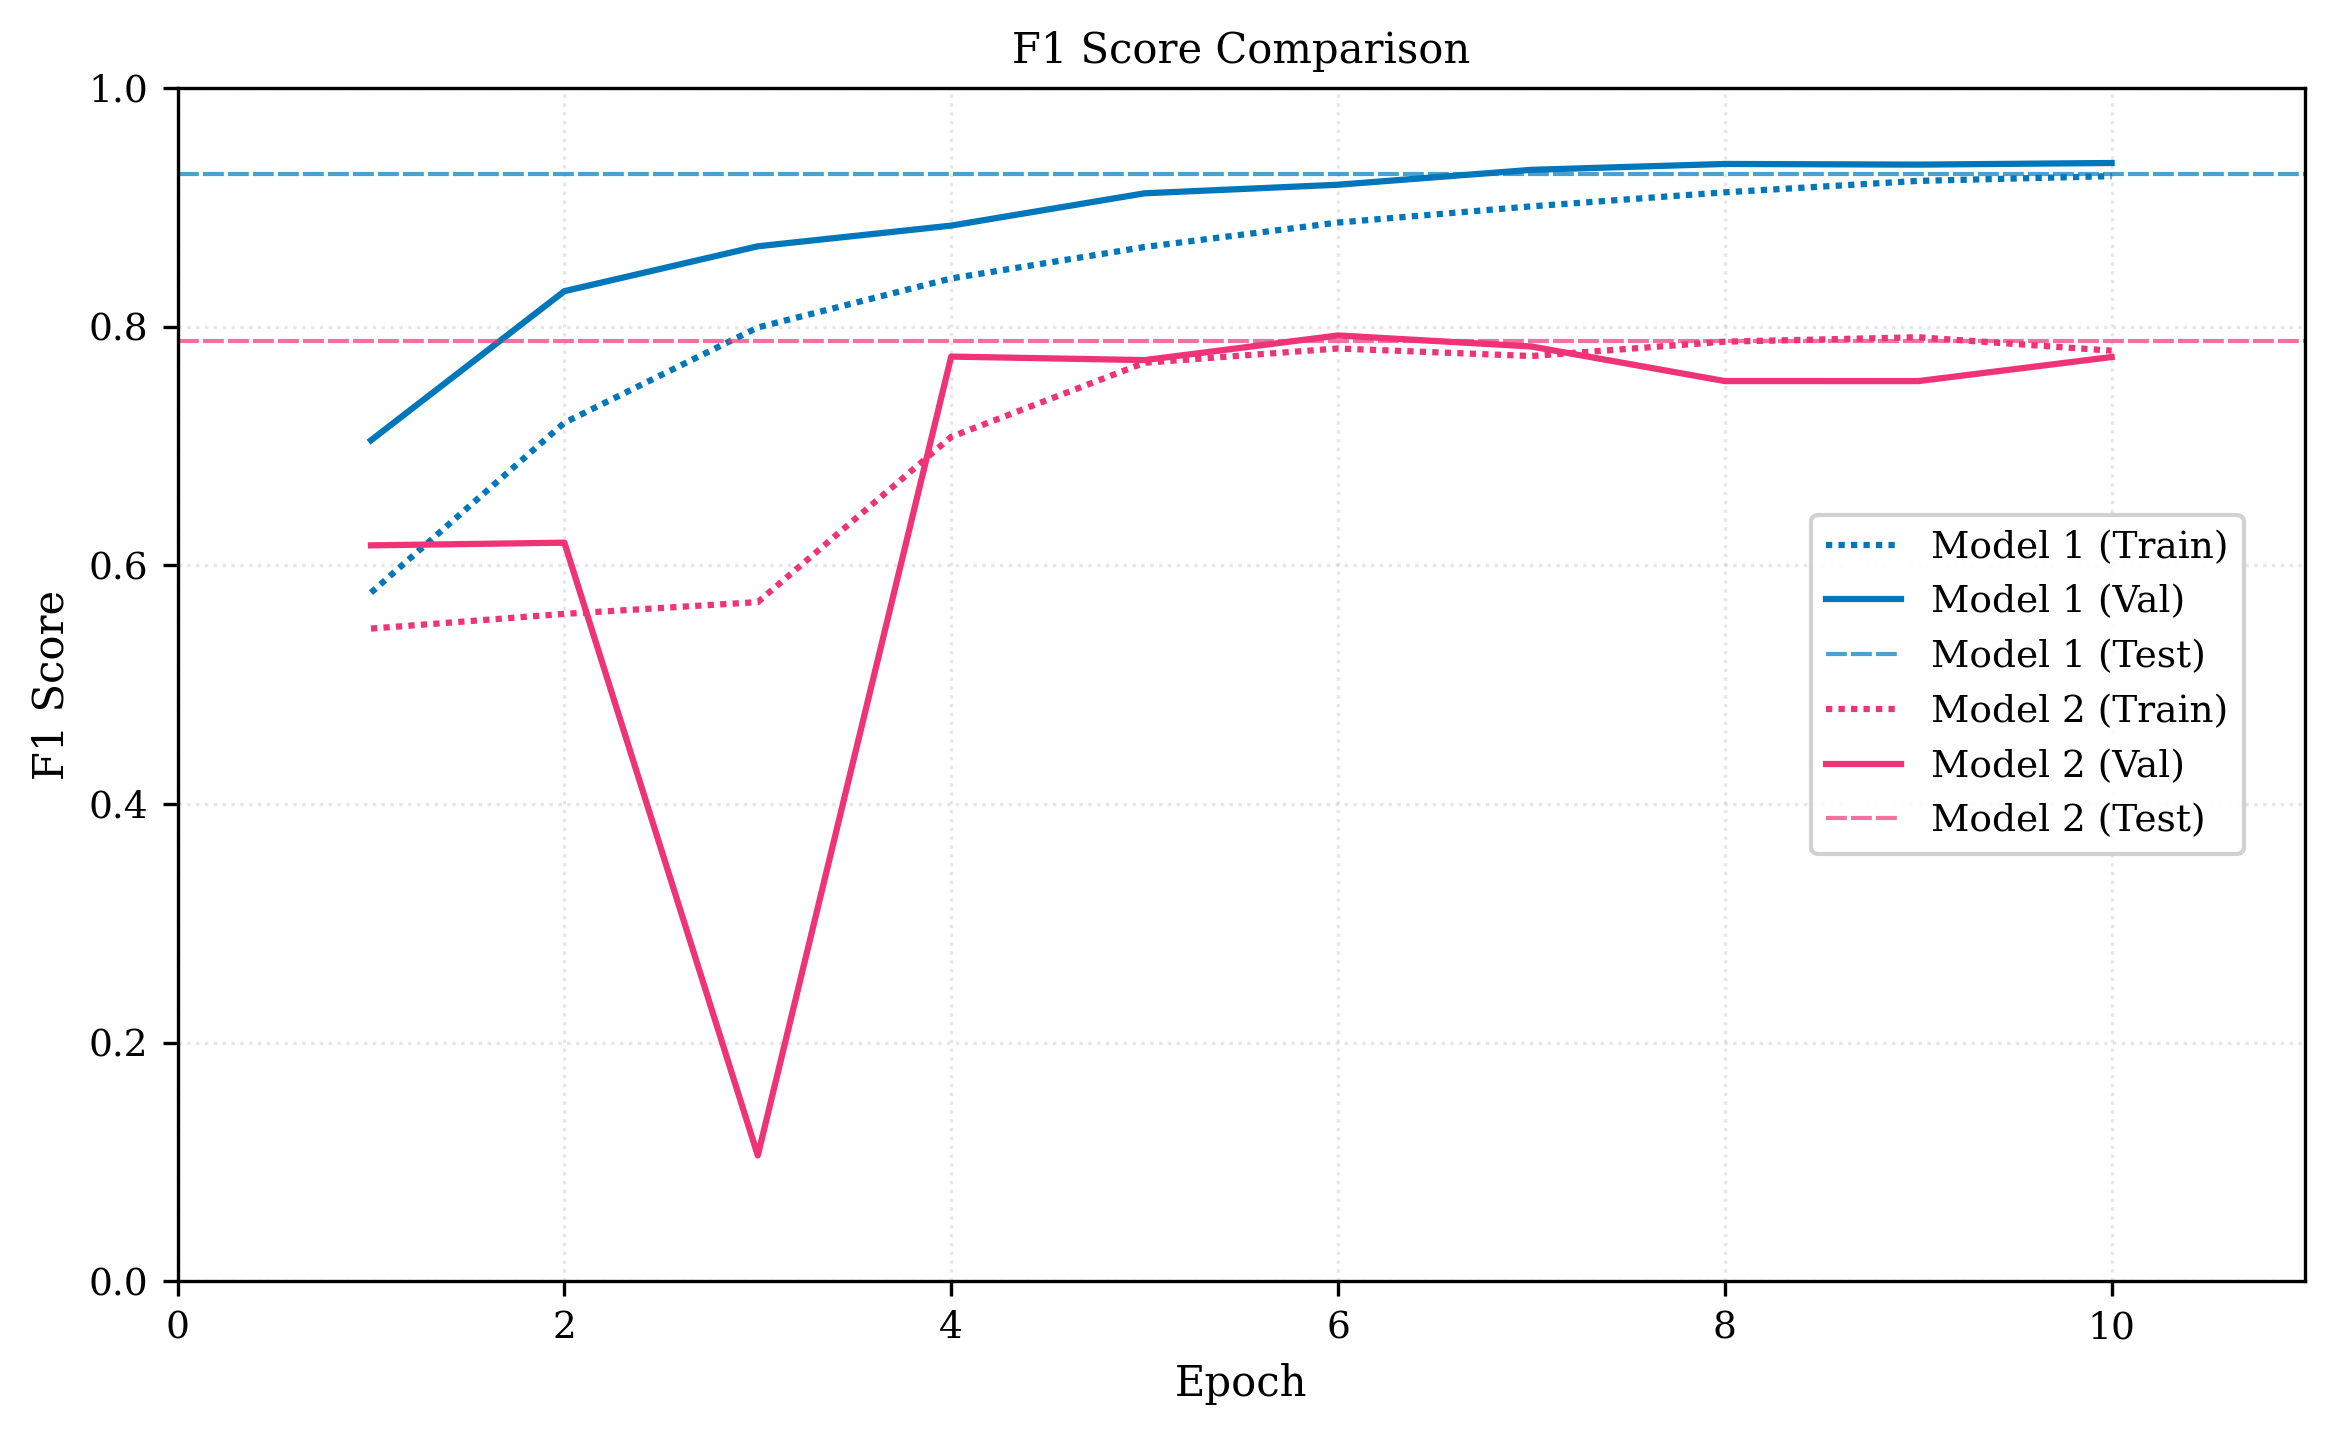

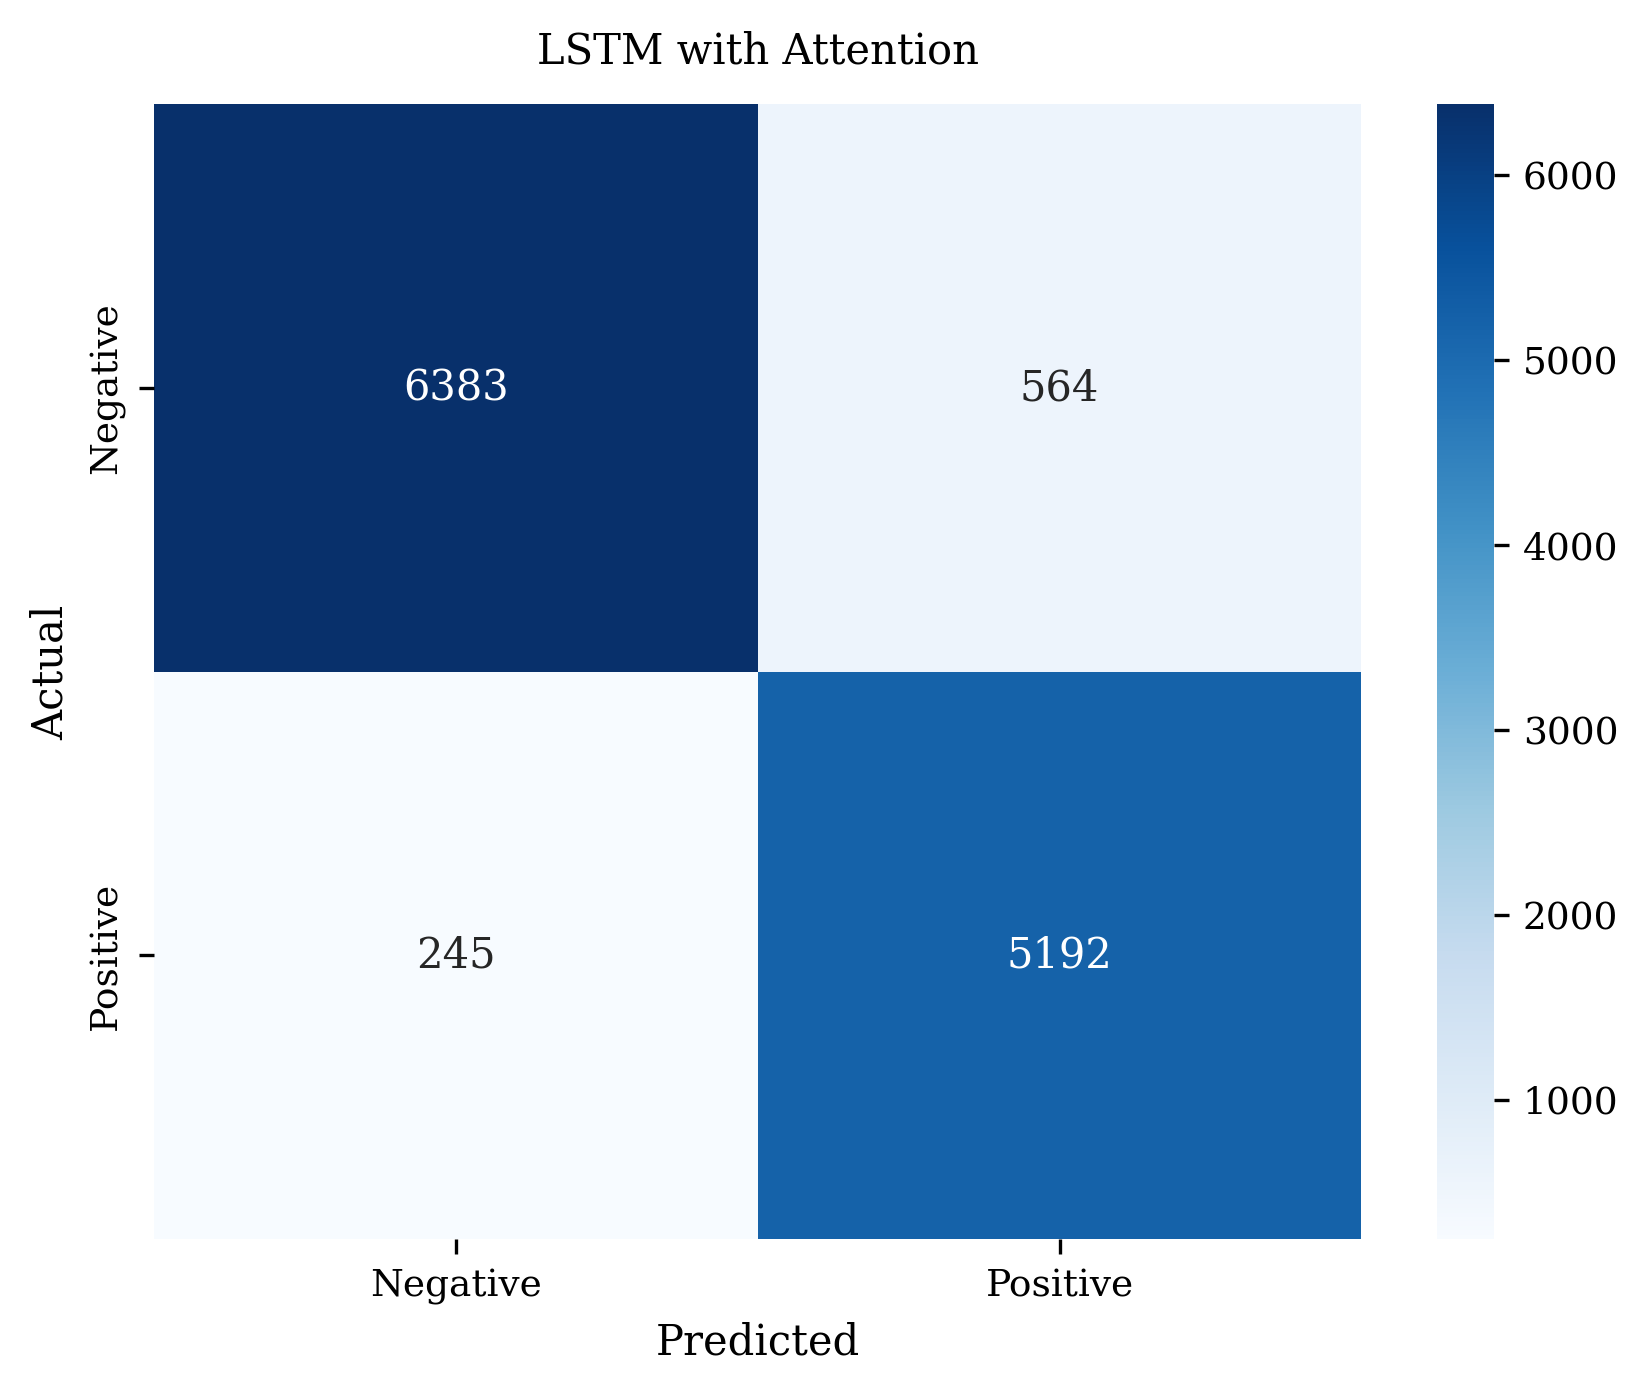

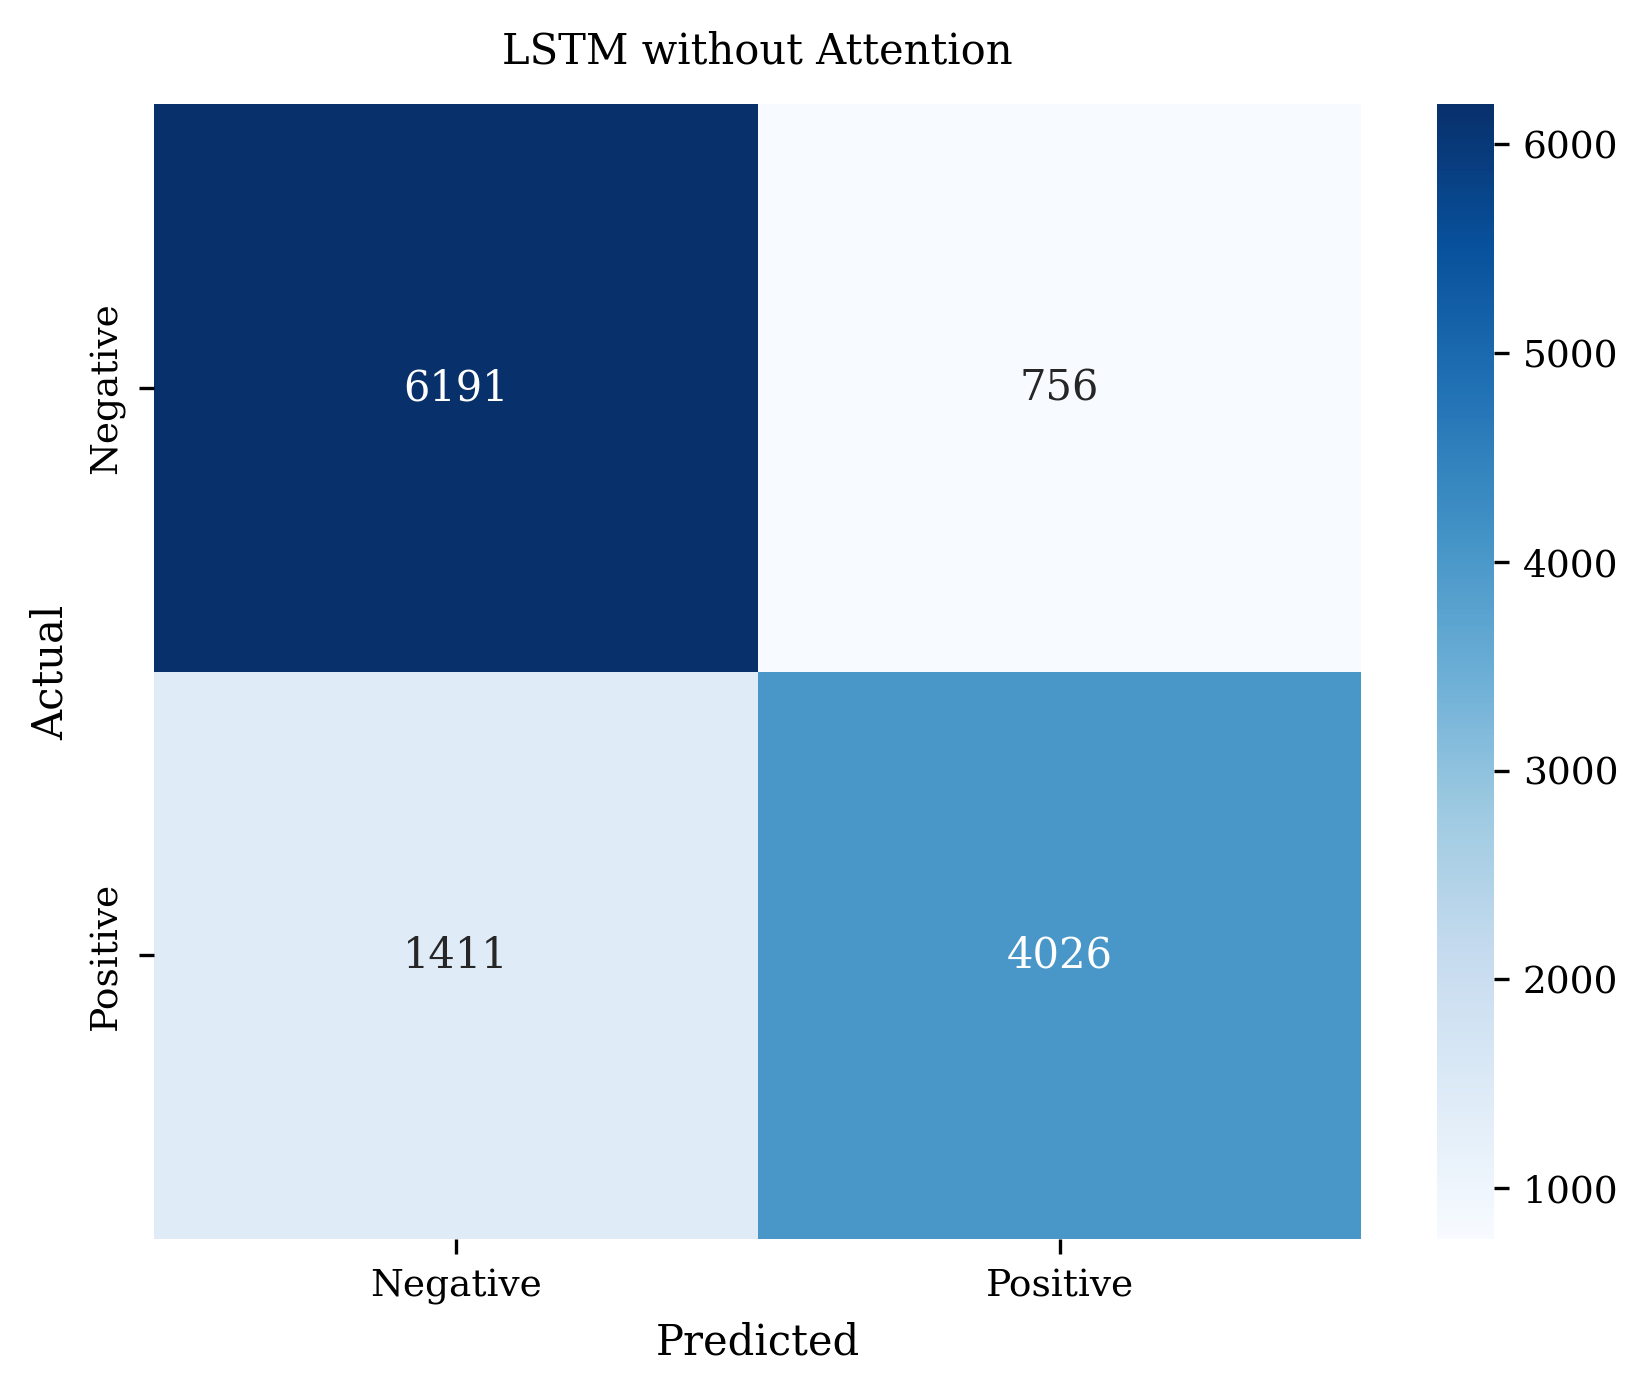

In [14]:
visualize_results(results)

In [12]:
def compare_models(results):
    print("\nModel Comparison:")
    print("-" * 50)

    # Compare training/validation metrics
    print("\nTraining/Validation Metrics (Key Values):")
    metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1_score']
    
    for metric in metrics_to_compare:
        print(f"\n{metric.upper()}:")
        
        for model_name in results:
            val_scores = results[model_name]['training_metrics'][metric]['val']
            final_score = val_scores[-1]
            best_score = max(val_scores)
            mean_score = np.mean(val_scores)
            
            print(f"{model_name}: Final: {final_score:.4f}, Best: {best_score:.4f}, Mean: {mean_score:.4f}")
    
    # Compare test metrics (display only final score)
    print("\nTest Metrics (Final Score):")
    for metric in metrics_to_compare:
        print(f"\n{metric.upper()}:")
        
        for model_name in results:
            test_score = results[model_name]['test_metrics'][metric]
            print(f"{model_name}: {test_score:.4f}")
            
compare_models(results)



Model Comparison:
--------------------------------------------------

Training/Validation Metrics (Key Values):

ACCURACY:
Model 1: Final: 0.9436, Best: 0.9436, Mean: 0.8901
Model 2: Final: 0.7868, Best: 0.8283, Mean: 0.7109

PRECISION:
Model 1: Final: 0.9174, Best: 0.9189, Mean: 0.8471
Model 2: Final: 0.7230, Best: 0.8994, Mean: 0.6945

RECALL:
Model 1: Final: 0.9578, Best: 0.9591, Mean: 0.9330
Model 2: Final: 0.8339, Best: 0.9665, Mean: 0.7418

F1_SCORE:
Model 1: Final: 0.9371, Best: 0.9371, Mean: 0.8858
Model 2: Final: 0.7745, Best: 0.7926, Mean: 0.6747

Test Metrics (Final Score):

ACCURACY:
Model 1: 0.9347
Model 2: 0.8250

PRECISION:
Model 1: 0.9020
Model 2: 0.8419

RECALL:
Model 1: 0.9549
Model 2: 0.7405

F1_SCORE:
Model 1: 0.9277
Model 2: 0.7879
